# CS156 - Location Based Assignment

## Core

Import some basic frameworks

In [1]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

**Note**
<div class="alert alert-info">Findings are written in this blue cell.
</div>

### Step 1. 
**includes the following:**
1. Processing all photos down to 512 pixels in both width and height
2. 10 sample images
3. Visualizing the relationship between the number of components and explained variance 



We first process all photose while recording its name and timestamp. 

In [2]:
# define path and pixel size
images_path = glob("/Users/ey08/Documents/Minerva/Fall 2022/CS156/LBA/images/*")
pixel = 512

In [3]:
flattened = []
img_name = []
timestamp = []
    
# for each image path
for path in images_path:
    # open it as a read file in binary mode
    with open(path, 'r+b') as f:
        # modify the load_image.py to retrieve image file name
        img_filename = os.path.splitext(str(f))[0]
        img_filename = img_filename.rsplit('/', 1)[1]
        img_name.append(img_filename)

        #open it as an image
        with Image.open(f) as image:
            # get timestamp (excluding date)
            timestamp.append(image.getexif()[306].split(" ")[1])
            # resize the image to be more manageable
            cover = resizeimage.resize_cover(image, [pixel,pixel]) 
            # 512,512
            # flatten the matrix to an array and 
            # append it to all flattened images
            flattened.append(np.array(cover).flatten())
            
# resize images using function
images = np.array(flattened)
n = len(images)
print(f'Total Images: {n}')
print(f'Images Shape: {images.shape}')

Total Images: 24
Images Shape: (24, 786432)


10 samples from original images are shown below.

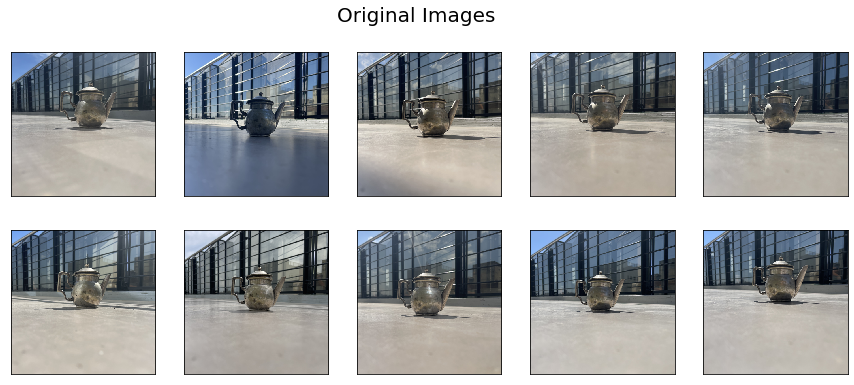

In [4]:
fig = plt.figure(figsize=(15,6)) 

# plot 10 samples of original images
for i in range(10): 
    ax = fig.add_subplot(2,5, i+1, xticks=[], yticks=[]) 
    img = Image.fromarray(images[i].reshape(pixel,pixel,3), 'RGB') 
    ax.imshow(img, interpolation='nearest') 
    
plt.suptitle('Original Images',size=20)

plt.show()

I also compare the degree of variance explained by each components and produce plot of cumulative variance explained.

The size of Dimensions is: 24
(24, 24)


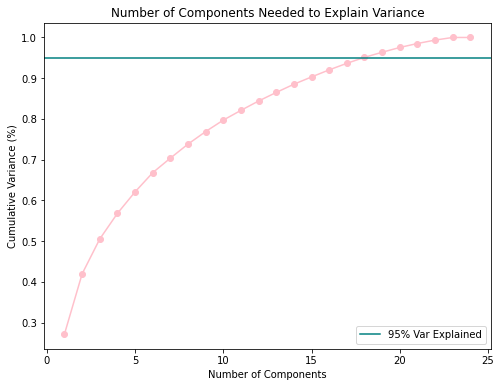

In [5]:
from sklearn import decomposition
# apply PCA using all components
print("The size of Dimensions is:",n)
pca_n = decomposition.PCA(n_components=n) 
#decomposes by n_components variables

# fit images to PCA to reduce dimensions
transformed = pca_n.fit_transform(images)

print(transformed.shape)
# plot number of components vs. explained variance
plt.figure(figsize=(8,6))

components = np.arange(1, n+1, step=1)
var = np.cumsum(pca_n.explained_variance_ratio_)

plt.plot(components, var, 'o-',color='pink')
plt.axhline(y=0.95, color='teal', label='95% Var Explained')

plt.title('Number of Components Needed to Explain Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')

plt.legend(loc=4)
plt.show()


In [6]:
# find the number of components explaining at least 95% of variance
n_com = np.absolute(var-0.95).argmin()+1
print(f"At n = {n_com}, {round(var[n_com-1],3)} of variance is explained.")

At n = 18, 0.951 of variance is explained.


<div class="alert alert-info">From the graph above, we can argue that the first three PCs explain more than half the variance of all images. Also, if we want to achieve 95% variance explained, we need to use 18 PCs.
</div>

### Step 2. 
**includes the following:**
1. Using principal components analysis (PCA) to project all images in a 2 dimensional representation

First, we construct PCA by using setting 2 as the number of components and fit input images to the PCA.

In [7]:
pca_2 = decomposition.PCA(n_components=2)
pca_2.fit(images)

PCA(n_components=2)

Then, we transform the original pictures based on the PCA constructed in the previous cell.

In [8]:
transformed = pca_2.transform(images)

### Step 3. 
**includes the following:**
1. scatter plot of all images in the 2D space
2. reconstructed and original version of all pictures

Since we fit PCA in the previous question and transformed the images, now we check the scatter plot of photos based on the projections in each principal component. 

/Users/ey08/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


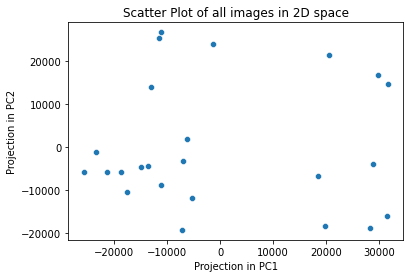

In [9]:
df = pd.DataFrame(transformed,columns=['PC1', 'PC2'])

sns.scatterplot(df['PC1'],df['PC2'])
plt.title("Scatter Plot of all images in 2D space")
plt.xlabel("Projection in PC1")
plt.ylabel("Projection in PC2")
plt.show()

<div class="alert alert-info">From the scatter plot above, we can see two differnt clusters: those with positive values in projection in PC1 and with negative ones. It may be because of the difference in timestamp of each picture. Since I took picture at my East-facing balcony, the luminance in pictures may differ between the morning and early afternoon (around 9am-3pm), and late afternoon (around 3-6pm).
    
Also, two axes in scatter plot tells us PC1 as its name suggests has wider variance explained than PC2.
</div>

Besides, we will show how each photo used for the input loads on the first two axes of the PCA projection and compare it against the original photo.

In [10]:
inversed = pca_2.inverse_transform(transformed)
formatted = np.clip(inversed, 0, 255).astype(np.uint8)

0.42 of variance is explained by the first two principal components.

Image on 2D PCA vs Original Images 


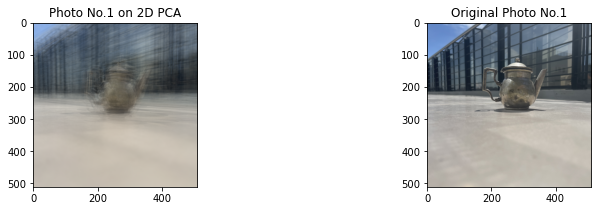

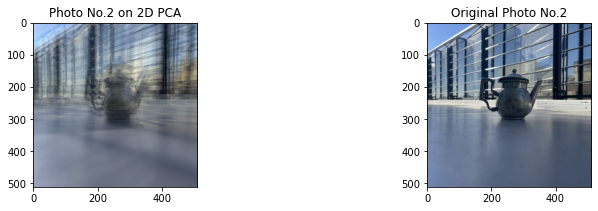

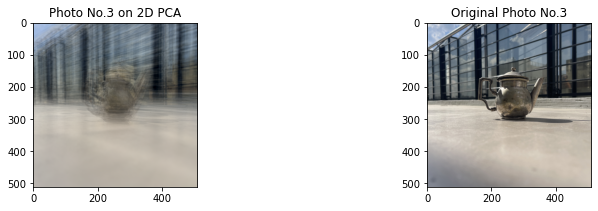

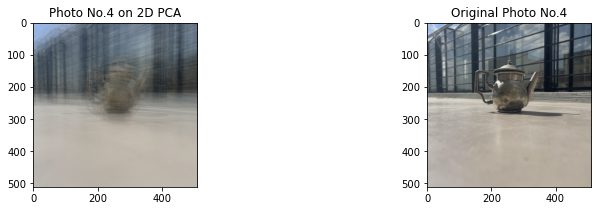

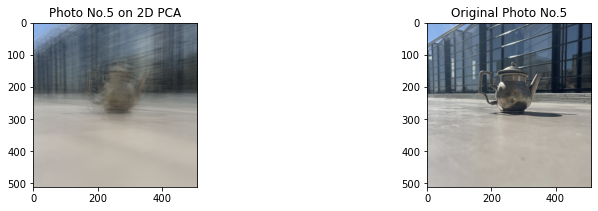

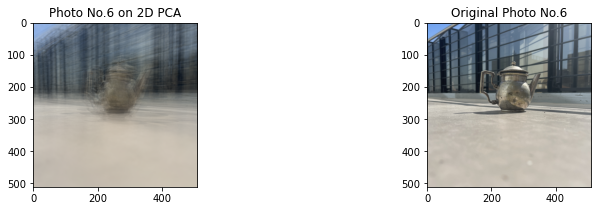

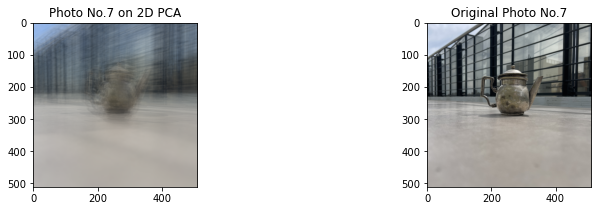

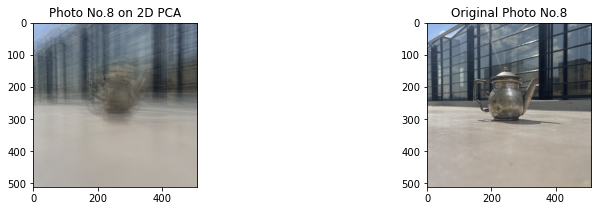

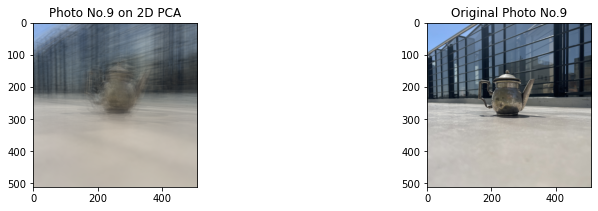

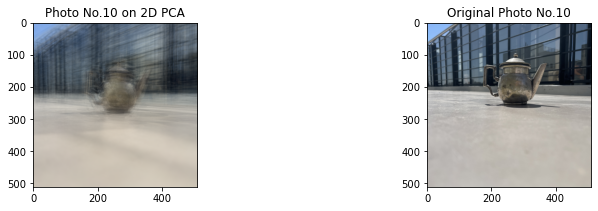

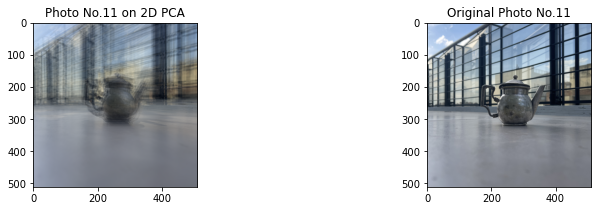

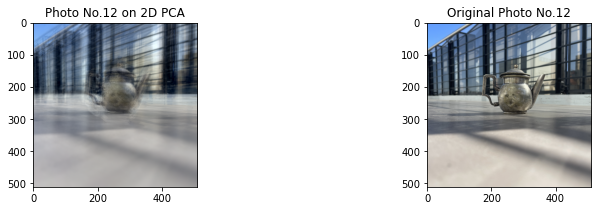

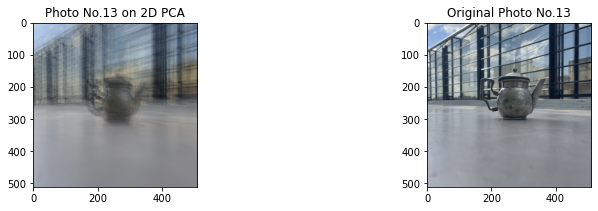

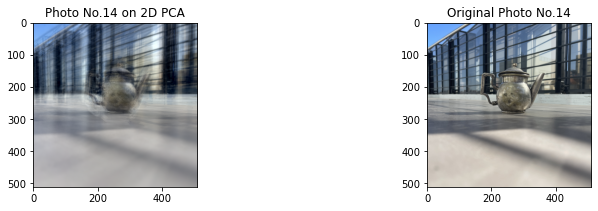

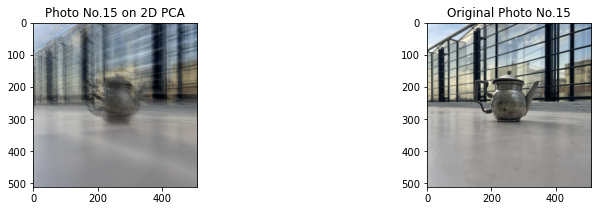

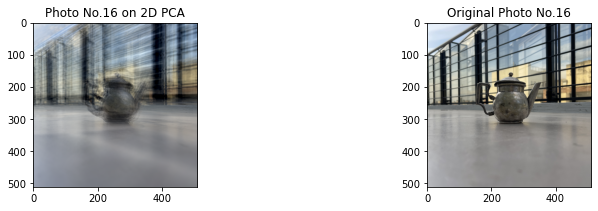

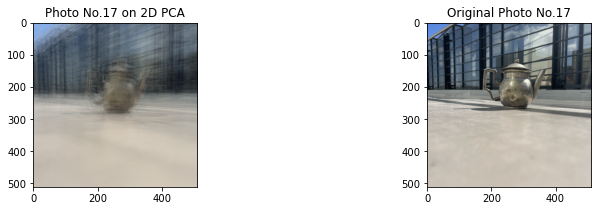

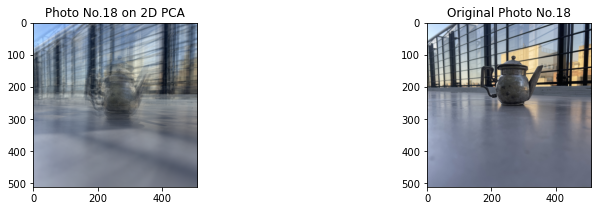

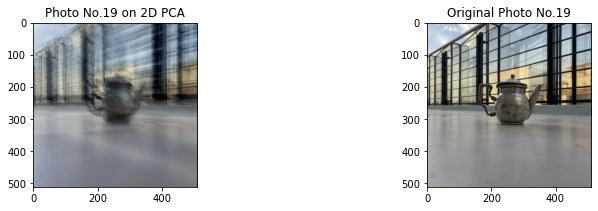

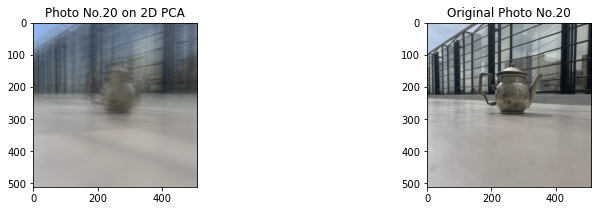

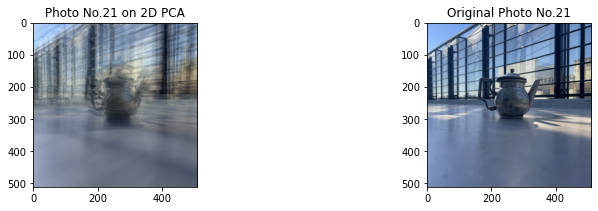

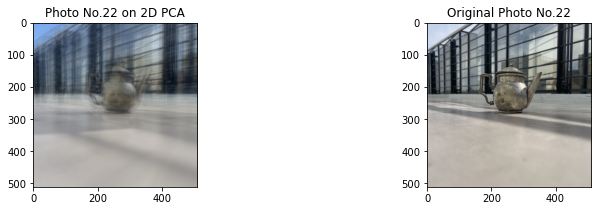

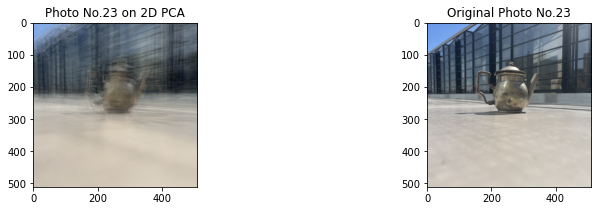

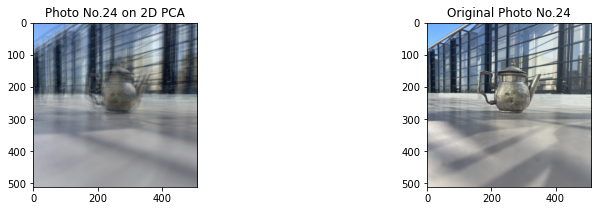

In [11]:
# calculate explained variance
pca_var_expl = np.round(np.cumsum(pca_2.explained_variance_ratio_)[-1],2)

print(f'{pca_var_expl} of variance is explained by the first two principal components.\n')

# set the title for image
print('Image on 2D PCA vs Original Images ')

# show the image loaded on 2D PCA on the left and original image on the right
for i in range(len(images)): 
    fig = plt.figure(figsize=(10,10)) 
    plt.subplot(1,3,1)
    plt.title(f'Photo No.{i+1} on 2D PCA')
    plt.imshow(Image.fromarray(formatted[i].reshape(pixel,pixel,3), 'RGB'))
    plt.subplot(1,3,3)
    plt.title(f'Original Photo No.{i+1}')
    plt.imshow(Image.fromarray(images[i].reshape(pixel,pixel,3), 'RGB'))
    plt.show()
    plt.close()
    
plt.show()

<div class="alert alert-info">From the comparison between picture on 2D PCA and its original version, we can see that 2D PCA considers shades created by balcony fence as very important factor varying from each picture. Fence's shade is particularly obvious from picture  No. 12, 14, and 24, but it appears in 2D PCA version of other pictures as well.
</div>

Aside from suggested core step, I constructed the loadings matrix and correlation matrix. 

Loadings matrix is given by the eigenvectors of the covariance matrix multiplied by the square roots of the respective eigenvalues. Positive loadings indicate a variable and a principal component vary together positively. Also, large loadings mean a variable has a strong effect on the specific principal component. 

In [12]:
loading = pca_2.components_.T * np.sqrt(pca_2.explained_variance_)
loading_matrix = pd.DataFrame(loading, columns=['PC1', 'PC2'])
loading_matrix

PC1        PC2
0       22.649721 -17.576049
1       16.078848  -8.422981
2        3.608333   6.220543
3       22.488718 -17.795175
4       16.087415  -8.652587
...           ...        ...
786427 -32.738002 -12.432757
786428 -23.462697  -7.534415
786429 -36.773691 -15.007472
786430 -32.577012 -12.516659
786431 -23.937996  -7.667688

[786432 rows x 2 columns]

<div class="alert alert-info">We can see that some feature give large positive influence over PC while other do the complete opposite, which coincides with the reconstructed image above where some shades and sky's color are reflected strongly. </div>

### Step 4. 
**includes the following:**
1. The reconstruction from each low-dimensional representation

The following codes calculate and record PCA results for dimension 1 to 24. One thing to note is that I choose the single sample image throughout reconstruction of each low-dimensional representation so that I can compare about the number of PCs influencing the picture's reproductibility.

In [13]:
# calculate PCA results and save image for each dimension
samples = []
expl_var = []
dims = []

for i in range(1,len(images)+1,1):
    
    # apply PCA
    pca = decomposition.PCA(n_components=i)

    # fit images to PCA to reduce dimensions
    transformed = pca.fit_transform(images)
    
    # transform image to save samples
    inverse = pca.inverse_transform(transformed)
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)
    
    # save one specific sample from each dimension
    sample = formatted[3]
    
    # calculate explained variance
    pca_var_expl = \
    np.round(np.cumsum(pca.explained_variance_ratio_)[-1],2)
    
    # save results
    samples.append(sample)    
    expl_var.append(pca_var_expl)
    dims.append(i)
    
# plot sample from each dimension

print("finished applying PCA")

finished applying PCA


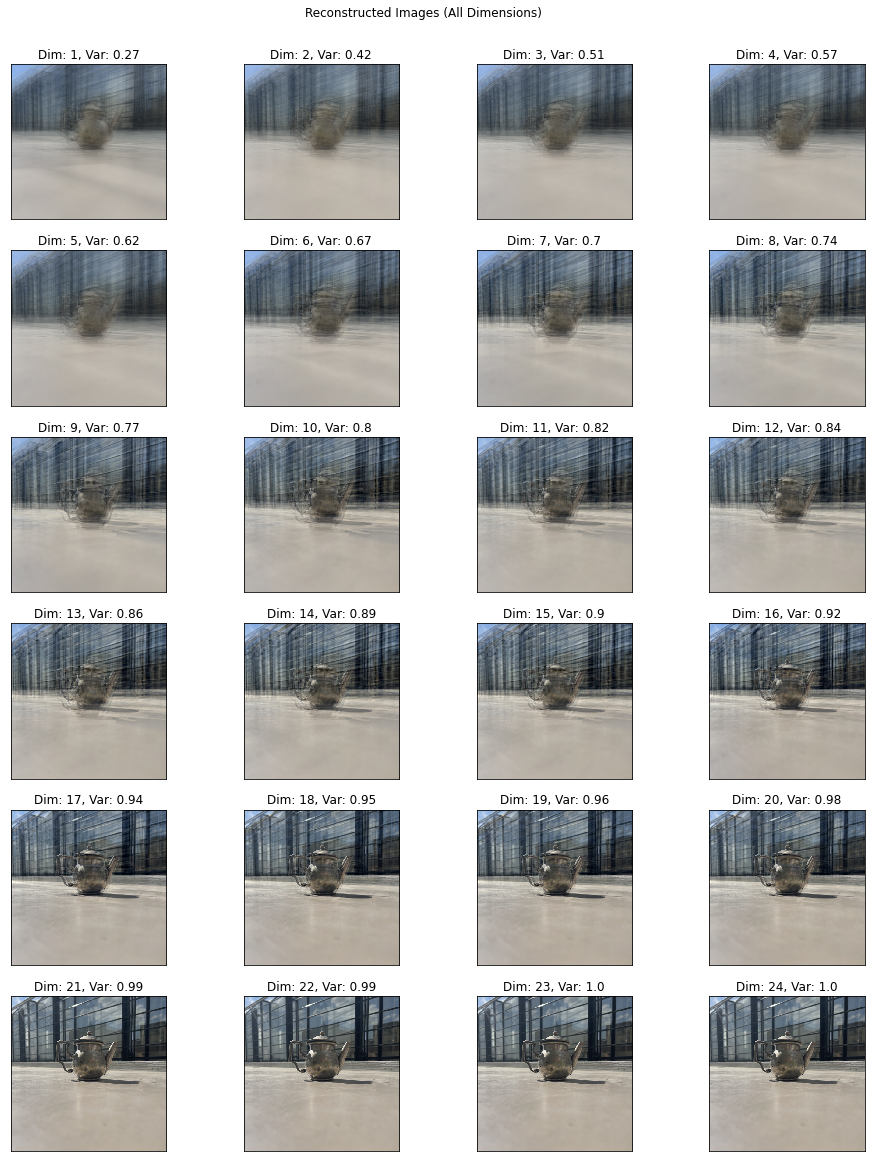

In [14]:
# reshape formatted samples
reshaped = []
for i in samples:
    new_img = Image.fromarray(i.reshape(pixel,pixel,3), 'RGB')
    reshaped.append(new_img)

# plot samples
fig = plt.figure(figsize=(16, 20)) 

for i in range(len(samples)): 
    ax = fig.add_subplot(6, 4, i+1, xticks=[], yticks=[]) 
    ax.imshow(reshaped[i], interpolation='nearest')
    ax.set_title(f'Dim: {dims[i]}, Var: {expl_var[i]}')
    
plt.suptitle('Reconstructed Images (All Dimensions)', y=0.92)

plt.show()

<div class="alert alert-info">From the reconstructed image above, we can tell that as the number of PCs used increase, we have clearer picture. 
In lower dimension, from Dimension 1 to around 12, the picture is highly blurred possibly because the small picture-angle differences. As more PCs added, variance between pictures becomes clearer, and we can see the boundary of color becomes more distinct. Picture keeps to be highly clear from 21-dimensional version and onward where explained variance exceeds 98%. 
</div>

### Step 5. 
**includes the following:**
1. picking a point that is far away from any known location and plot its reconstruction

From the figure below, we can see that the orange point (5000, 5000) can be far away from any plotted points.

/Users/ey08/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


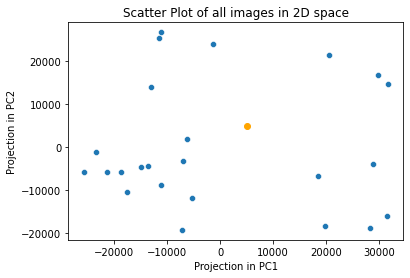

In [15]:
fig = sns.scatterplot(df['PC1'],df['PC2'])
plt.scatter(5000, 5000, marker='o',c="orange")
plt.title("Scatter Plot of all images in 2D space")
plt.xlabel("Projection in PC1")
plt.ylabel("Projection in PC2")
plt.show()

Therefore, we take this point and reconstruct an image from it.

In [16]:
inverse = pca_2.inverse_transform([[5000,5000]])
formatted = np.clip(inverse, 0, 255).astype(np.uint8)
new_img = Image.fromarray(formatted.reshape(pixel,pixel,3), 'RGB')

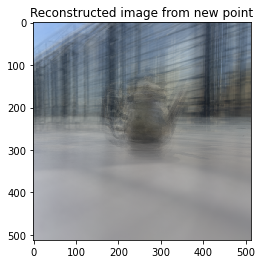

In [17]:
plt.imshow(new_img, interpolation='nearest')
plt.title("Reconstructed image from new point")
plt.show()

<div class="alert alert-info">As we can see from the image above, the picture is blurry. However, this new picture still captures the basic components of all existing pictures used for input of PCA, such as pot, fence, and sky.
</div>

In the cell below, we try image reconstruction from a new point for all 24 dimensions. In choosing a new point, I select 5000 in each dimension.

In [18]:
# calculate PCA results and save image for each dimension
newpoint_lst = []

for i in range(1,len(images)+1,1):
    
    # apply PCA
    pca = decomposition.PCA(n_components=i)

    # fit images to PCA to reduce dimensions
    pca.fit(images)
    
    # transform image to save samples
    inverse = pca.inverse_transform([[5000]*i])
    formatted = np.clip(inverse, 0, 255).astype(np.uint8)

    # save results
    newpoint_lst.append(formatted)    
    
# plot sample from each dimension

print("finished applying PCA")

finished applying PCA


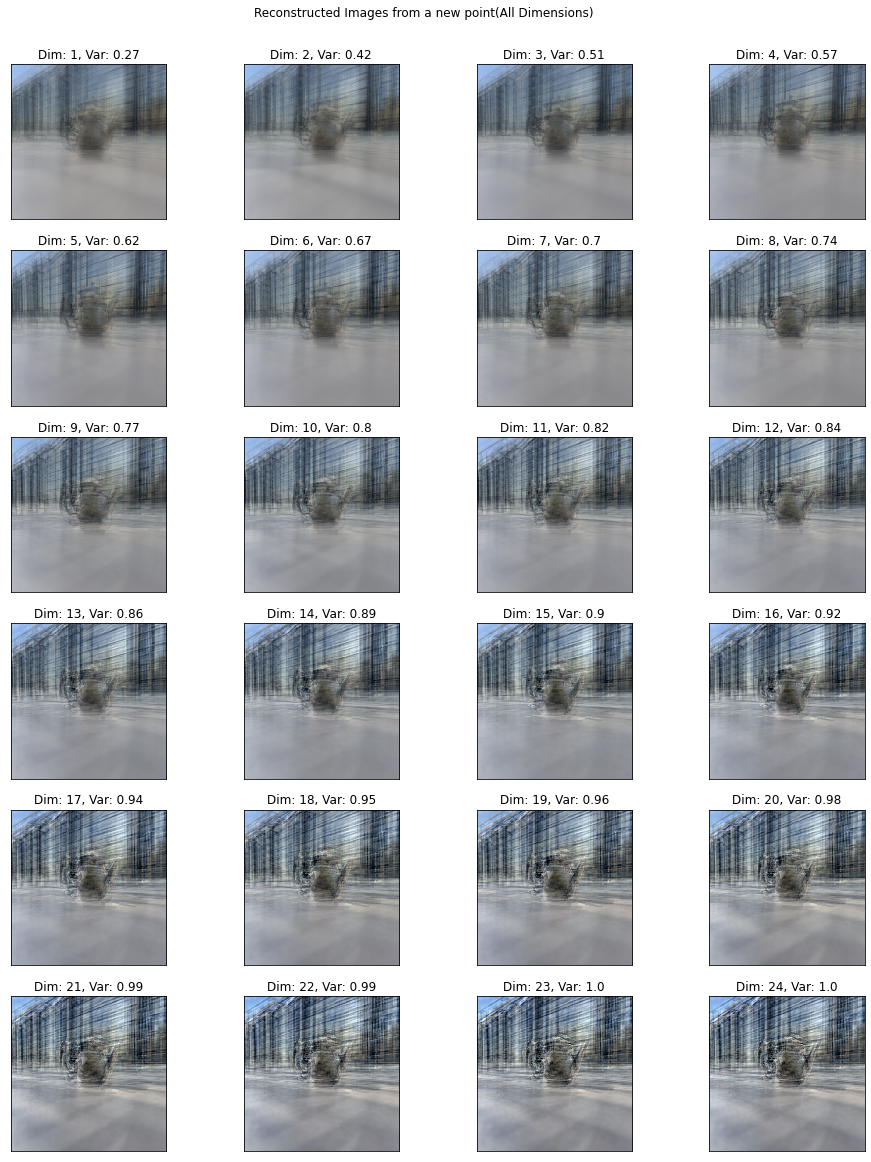

In [19]:
# reshape formatted samples
reshaped_newpoint = []
for i in newpoint_lst:
    new_img = Image.fromarray(i.reshape(pixel,pixel,3), 'RGB')
    reshaped_newpoint.append(new_img)

# plot samples
fig = plt.figure(figsize=(16, 20)) 

for i in range(len(samples)): 
    ax = fig.add_subplot(6, 4, i+1, xticks=[], yticks=[]) 
    ax.imshow(reshaped_newpoint[i], interpolation='nearest')
    ax.set_title(f'Dim: {dims[i]}, Var: {expl_var[i]}')
    
plt.suptitle('Reconstructed Images from a new point(All Dimensions)', 
             y=0.92)

plt.show()

<div class="alert alert-info"> As we get more dimension, the picture has more color intensity and clarity. One notable difference from the previous reconstructed images for all dimensions is that even in higher dimensions, there is no one clear image constructed as presumably it is the mixture of all input pictures with different extent.
</div>

## Extension

**includes the following:**
1. Timestamp Prediction with Linear Regression Model
    - with comparison between PCA and non-PCA version
    - model evaluation
2. Classification Prediction with Multi-layer perceptron (MLP) classifier
    - model evaluation
3. Additional visualization using other PCA library

### 1. Timestamp Prediction with Linear Regression Model

**includes the following:**
1. Constructing dataframe from images
2. Adding timestamp to dataframe 
3. Splitting the dataset into train and test set
4. Normalizing the dataset
5. Applying PCA
6. Timestamp prediction with Linear Regression model on PCA-applied data
7. Evaluation of prediction using MAE and MRSE
8. Timestamp prediction with Linear Regression model on non-PCA-applied data
9. Evaluation of prediction using MAE and MRSE

We construct the dataframe based on all values on the images' pixel. Here, for easy analysis...
1. I assume all the pictures are taken on the same day
2. I convert the datetime to numeric value (amount of time passed since 1970-01-01) for linear regression analysis

In [20]:
new_df = pd.DataFrame(images)
new_df['Image Name'] = img_name

# simplify by assuming timestamp falling in a single day
new_df['Time(timestamp)'] = pd.to_datetime(timestamp) 

# convert to numeric value for easier comparison
new_df['Time(numeric)'] = pd.to_numeric(new_df['Time(timestamp)']) 

# Variables
X= new_df.drop(labels= ['Image Name', 'Time(timestamp)','Time(numeric)'], 
               axis= 1)
y= new_df['Time(numeric)']

Next, we split the data into train and test set for each predictor and target variables.

In [21]:
X_train, X_test, y_train, y_test =\
train_test_split(X,y, test_size=0.3, random_state=0)

<div class="alert alert-warning">
Before performing PCA, as an extension exercise, I <strong>normalize</strong> the data to have a accurate comparison for variance. Since PCA is to find a (set of) PC(s) with the maximum variance and each variable in dataset has distinctive covariance matrix, the variance should be normalize across the variables to perform a better PCA. Otherwise, during PCA, there could be a chance to choose the axis with overrated explanatory power.
</div>

In [22]:
# standardized 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Then, I use 3 as the number of components in conducting PCA.

In [23]:
# apply PCA
pca_3 = decomposition.PCA(n_components=3)
pca_3.fit(X_train)
X_train_pc = pca_3.transform(X_train)
X_test_pc = pca_3.transform(X_test)

In [24]:
# fit and train linear regression model with data with reduced dimension 
# through PCA
import time
model_pca = LinearRegression()
before = time.time()
model_pca.fit(X_train_pc, y_train)
after = time.time()
fit_time_pc = after-before
print(f'fit took {fit_time_pc:.2f}s') #fit took 0.05s

# predict time label
y_pred_pc = model_pca.predict(X_test_pc)

fit took 0.01s


In [25]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
  
mae_pc = mean_absolute_error(y_test, y_pred_pc)
#squared True returns MSE value, False returns RMSE value.
rmse_pc = mean_squared_error(y_test, y_pred_pc,squared=False)
  
print(f'MAE in value {mae_pc:.2f} and in time {pd.to_timedelta(mae_pc)}')
print(f'RMSE in value {rmse_pc:.2f} and in time {pd.to_timedelta(rmse_pc)}')

MAE in value 7542876913056.00 and in time 0 days 02:05:42.876913056
RMSE in value 9438647436551.18 and in time 0 days 02:37:18.647436551


<div class="alert alert-info">From MAE, we can tell the error between predicted timestamp and actual one is generally around 1 hour, which is relatively good given that 1 hour difference during daytime does not largely influence the view of the world. Besides, from the combination of MAE and RMSE, we can also see that not so many outliers exist since RMSE is more influenced by the outliers rather than MAE but those two values do not significantly differ from one another.
</div>

We also construct and fit the linear regression model without PCA to compare the time for training and error rate.

In [26]:
# fit and train linear regression model with data with original dimension
model = LinearRegression()
before = time.time()
model.fit(X_train, y_train)
after = time.time()
fit_time = after-before
print(f'fit took {fit_time:.2f}s') #fit took 0.78s

# predict time label
y_pred = model.predict(X_test)

fit took 0.41s


In [27]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred,squared=False)
  
print(f'MAE in value {mae:.2f} and in time {pd.to_timedelta(mae)}')
print(f'RMSE in value {rmse:.2f} and in time {pd.to_timedelta(rmse)}')

MAE in value 6325786598560.00 and in time 0 days 01:45:25.786598560
RMSE in value 9438324023781.22 and in time 0 days 02:37:18.324023781


<div class="alert alert-info"> 
    In non-PCA version, it takes more time for training (e.g., PCA: 0.06s, non-PCA: 0.29s) since the dimensions are not reduced and machine has to learn from large inputs inefficiently. 
    Besides, speaking of MAE and RMSE, non-PCA version has slightly larger error comparing to PCA one although both are generally around 1 hour. From this comparison, we can tell that PCA is very efficient by reducing the dimension while saving the principal components critical for image constructions.
</div>

### 2. Classification Prediction with Multi-layer perceptron (MLP) classifier

First of all, I check the timestamp so that we can categorize the photos into two groups.

In [28]:
new_df['Time(timestamp)'].sort_values()

23   2022-09-30 09:35:41
11   2022-09-30 09:47:45
13   2022-09-30 09:48:00
21   2022-09-30 10:29:32
16   2022-09-30 10:54:30
5    2022-09-30 11:17:08
22   2022-09-30 11:40:54
6    2022-09-30 11:42:09
0    2022-09-30 12:41:56
8    2022-09-30 13:32:03
9    2022-09-30 13:32:21
7    2022-09-30 13:51:54
19   2022-09-30 14:31:42
4    2022-09-30 14:53:38
3    2022-09-30 14:59:03
2    2022-09-30 15:10:47
1    2022-09-30 15:55:26
12   2022-09-30 16:02:40
20   2022-09-30 16:25:36
10   2022-09-30 17:06:26
14   2022-09-30 17:36:54
15   2022-09-30 17:49:36
17   2022-09-30 18:12:03
18   2022-09-30 18:17:16
Name: Time(timestamp), dtype: datetime64[ns]

From the output above, we find timestamp from 9am to 6pm. Since 2pm is when the sun generally goes away from the east to which our balcony faces, we divide the photos into the following two categories:

0. taken (strictly) before 2pm (i.e., 2022-09-30 14:00:00)
1. taken after 2pm

Thus, we create another column called 'Photo Category' that defines categories based on the rule above. Since there are only two categories, we can use 0 and 1 to show if the hour is before 2pm or not and do not have to encode in one-hot encoding which can cause multicollinearity if we do not drop one of two newly created columns.

In [29]:
# return 0 if the picture is taken before 2pm 
def converter(timestamp):
    if timestamp.hour < 14:
        return 0
    else:
        return 1
new_df['Photo Category'] = new_df['Time(timestamp)'].apply(converter)

Then, I create the explanatory and target variables.

In [30]:
# Variables
X = new_df.drop(labels= ['Image Name', 'Time(timestamp)','Time(numeric)'], 
                axis= 1) 
y = new_df['Photo Category']

In the cell below, I construct a pipeline of normalization, PCA with 3 PCs, and MLP classifier to be used for k-fold crossvalidation. I use 4 folds given our limited sample size (n=24). 

I use MLP classifier since it can overcome potential problems in my datasets. First, it is good at learning complex non-linear models since it uses weight coefficients. Given that each pixel is independent from one another, learning images involves complex and non-linear process. Secondly, MLP classifier can attain the same accuracy ratio regardless of the sample size. Since we only have 24 image inputs, which is immensely small considering the number of pixels machine has to learn from, MLP classifier is advantageous.

<div class="alert alert-warning">
I made the above pipeline so that normalization and PCA can be done per each round of crossvalidation. It is important because k-fold crossvalidation is essentially doing train-split k times, and we need to maker sure that one train-split results may not influence another one so that machine can avoid overfitting and achieves a quality prediction with unknown dataset as well.
</div>

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier

pipeline = make_pipeline(StandardScaler(),
                         decomposition.PCA(n_components=3), 
                         MLPClassifier(random_state=1, max_iter=300))

In [32]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

# 4 fold
cv = KFold(n_splits=4, random_state=1, shuffle=True)

y_pred = cross_val_predict(pipeline, X, y, cv=cv)

/Users/ey08/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/ey08/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/ey08/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/ey08/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/ey08/

To visualize the classifier's quality, I compute accuracy score and construct confusion matrix and classification report.

Classifier Report
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.75      0.86        12

    accuracy                           0.88        24
   macro avg       0.90      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24



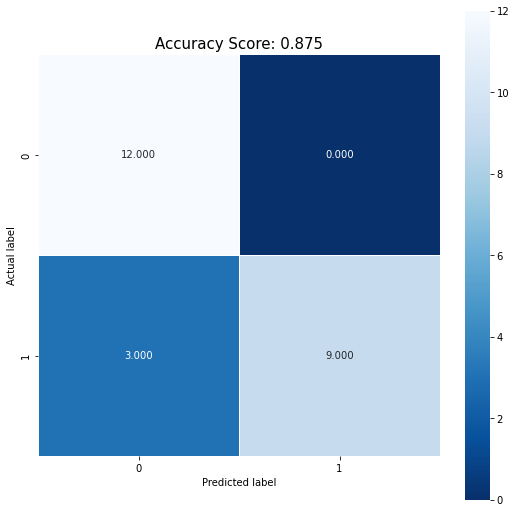

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y, y_pred))
plt.title(all_sample_title, size = 15)

# classifier report
print("Classifier Report\n",classification_report(y, y_pred))

<div class="alert alert-info"> 
We attain 87.5% accurate as suggested in accuracy score. Also, from the confusion matrix, we can see there are 3 false positive results (predicted label is 0 but actual one is 1). It may be rooting from the weather variance across different days; since pictures are from 4 days and we did not let machine consider the weather difference, its prediction is not accurate enough to account for very sunny day where the picture may look brighter than the picture from other days with the same time. It tells us the importance of initial data input and consistent yet various data to be collected.
</div>

### 3. Additional visualization using other PCA library

I've found a PCA library which generates some interesting and helpful visualizations, so I tried it below. 

In [ ]:
# pip install pca

In [35]:
from pca import pca as PCA

In [36]:
model = PCA(n_components=3)

# Fit transform
results = model.fit_transform(images)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [786432] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


The code below produces the cumulative variance explained, which is the same as one I constructed as the first plot.

[0.27201403 0.41962897 0.5053039 ]
[0.27201403 0.14761494 0.08567494]


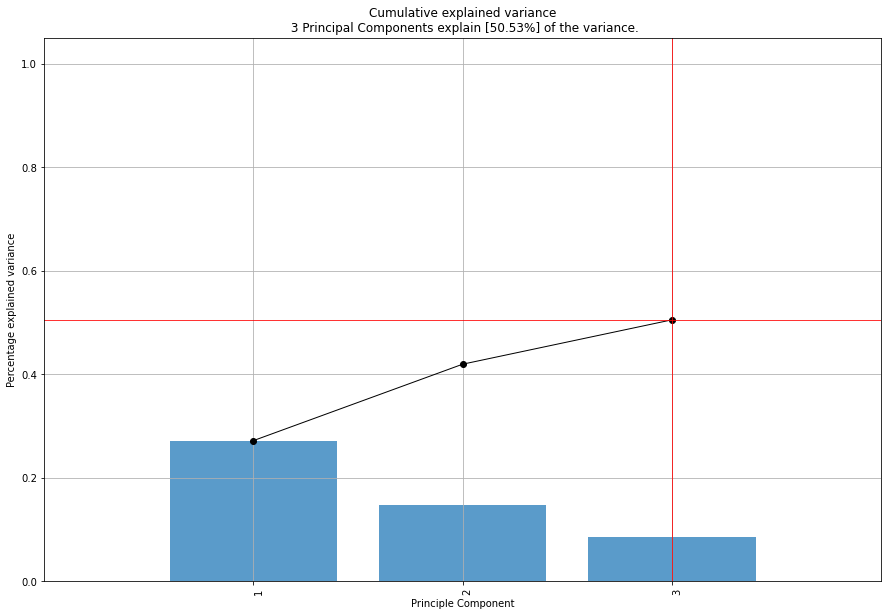

<Figure size 432x288 with 0 Axes>

In [37]:
# Cumulative explained variance
print(model.results['explained_var'])

# Explained variance per PC
print(model.results['variance_ratio'])

# Make plot
fig, ax = model.plot()

The result below show the top-scoring features. Same features can be recorded for different PC since PC stores the one with the highest absolut loading. "weak" feature means the one never detected for any PCs, which signifies that it has less contribution to machine's training process.

In [38]:
results['topfeat']

PC feature   loading  type
0       PC1  247084  0.003132  best
1       PC2  216199  0.005202  best
2       PC3  353026 -0.005600  best
3       PC2       1 -0.001198  weak
4       PC1       2  0.000808  weak
...     ...     ...       ...   ...
786427  PC1  786428 -0.001644  weak
786428  PC1  786429 -0.001178  weak
786429  PC1  786430 -0.001847  weak
786430  PC1  786431 -0.001636  weak
786431  PC1  786432 -0.001202  weak

[786432 rows x 4 columns]

Besides, the 2D and 3D biplots below show the scatter of different images in 2D and 3D space, with how the top n number of features capture the variance.

<div class="alert alert-info"> 
Visually, more variation is explained in 3D than 2D as the each datapoint scatters further away, which also explains why the higher dimensional space produces pictures of higher quality. Beside, We can tell from the overlapping/thick red lines, which signifies the loading of top features, that except for the first few features with large and distinctive vector in loadings, the rest are relatively similar in size and direction.
</div>

[pca] >Plot PC1 vs PC2 with loadings.


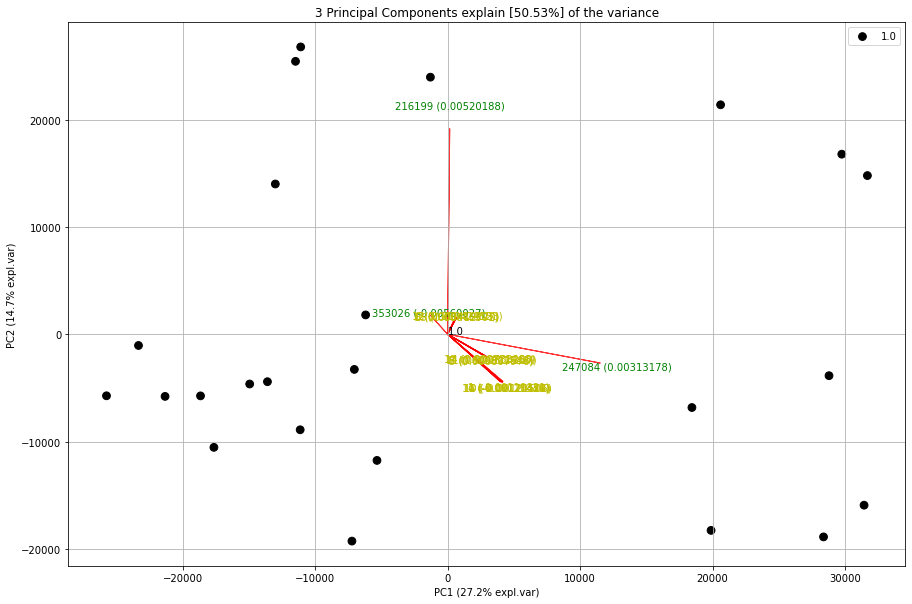

In [39]:
# 2D plot
fig, ax = model.biplot(n_feat=20, PC=[0,1])


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


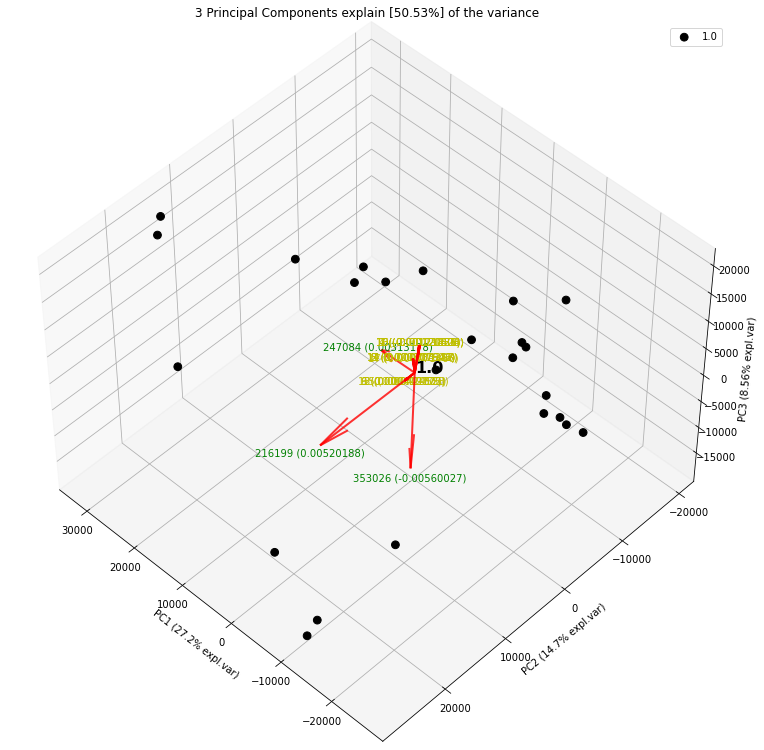

In [40]:
# 3d Plot
fig, ax = model.biplot3d(n_feat=20, PC=[0,1,2])